In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../../libTLDA/

/atlas/u/kechoi/libTLDA


----

# Load data

In [12]:
import numpy as np
import numpy.random as rnd
import torch

from sklearn.linear_model import LogisticRegression
from libtlda.iw import ImportanceWeightedClassifier

"""Generate synthetic data set"""

'Generate synthetic data set'

In [5]:
rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
X = rec['x']
y = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
Z = rec['x']
u = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']

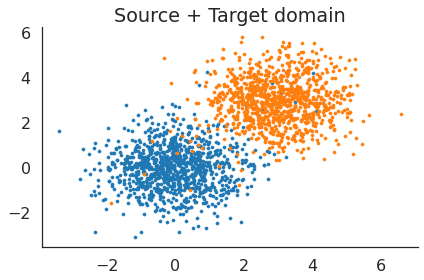

In [6]:
plt.scatter(X[:,0], X[:,1], s=10)
plt.scatter(Z[:,0], Z[:,1], s=10)

plt.title('Source + Target domain')
sns.despine()
plt.tight_layout()

In [9]:
# Train via KMM
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.05)
clf.fit(X, y, Z)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

     pcost       dcost       gap    pres   dres
 0:  5.0469e+02 -3.2215e+04  3e+04  1e-16  1e+03
 1:  4.9481e+02 -3.1307e+03  4e+03  3e-16  1e+02
 2:  4.7565e+02  3.2915e+02  1e+02  3e-16  2e-14
 3:  4.7409e+02  4.7249e+02  2e+00  3e-16  7e-15
 4:  4.7403e+02  4.7402e+02  2e-02  1e-16  9e-15
 5:  4.7403e+02  4.7403e+02  2e-04  2e-16  6e-15
Optimal solution found.
Error naive: 0.297
Error adapt: 0.26


In [10]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.248


# Load pre-trained flow

In [11]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [13]:
device = 'cuda'
restore_file = 'flows/results/kmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
print(state['epoch'])

85


In [14]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/kmm_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cuda')
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

Text(0.5, 1.0, 'Source + Target')

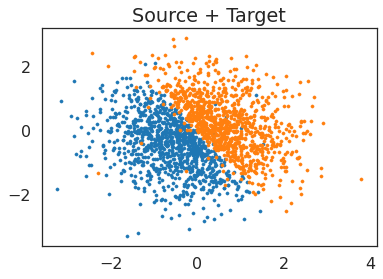

In [15]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cuda().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cuda().float())

plt.scatter(flow_train_x[:,0].data.cpu().numpy(), flow_train_x[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy(), flow_test_x[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')

In [16]:
# on target
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.1)
clf.fit(flow_train_x.data.cpu().numpy(), y, flow_test_x.data.cpu().numpy())
pred_adapt = clf.predict(flow_test_x.data.cpu().numpy())

print('Error adapt in z-space: ' + str(np.mean(pred_adapt != u, axis=0)))

     pcost       dcost       gap    pres   dres
 0:  6.6780e+02 -3.2202e+04  3e+04  3e-17  3e+02
 1:  6.5183e+02 -2.9739e+03  4e+03  1e-16  3e+01
 2:  6.2499e+02  5.0027e+02  1e+02  1e-16  6e-15
 3:  6.2102e+02  6.1662e+02  4e+00  2e-16  3e-14
 4:  6.2090e+02  6.2064e+02  3e-01  5e-16  1e-13
 5:  6.2089e+02  6.2089e+02  4e-03  6e-16  5e-13
 6:  6.2089e+02  6.2089e+02  5e-05  9e-16  3e-12
Optimal solution found.
Error adapt in z-space: 0.238


In [17]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.213


### previous results

(on target)
- Error naive: 0.297
- Error adapt: 0.26
 
(on target_test)
- Error naive: 0.286
- Error adapt: 0.248

What happens for z-space LR?

In [20]:
# Train a naive logistic regressor
z_lr = LogisticRegression().fit(flow_train_x.data.cpu().numpy(), y)

# Make predictions
pred_naive = z_lr.predict(flow_test_x.data.cpu().numpy())
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive: 0.635


In [21]:
pred_naive_test = z_lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive: 0.629
